In [2]:
#Importing EDA related functions
import numpy as np
import os
import pandas as pd
from pandas.plotting import autocorrelation_plot
from datetime import datetime 

from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
#import matplotlib.pylab as plt #for visualization

In [3]:
#Importing Time series Related Functions
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.ensemble import IsolationForest

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose

#Taking datetime index as reading csv
def parser(x):  
    return datetime.strptime(x,'%m/%d/%y')  
dataset = pd.read_csv('27IndiaConfirmed.csv',header=0, delimiter=',',index_col=0, parse_dates=[0], date_parser=parser)  


In [11]:
dataset = pd.read_csv('29IndiaConfirmed.csv',header=0, delimiter=',')
dataset["DailyCases"]=0
print(dataset.head(),"\n")
print(dataset.tail(5),"\n")
print(dataset.info(),"\n")
print(dataset.dtypes,"\n")


       Date  ConfirmedCases  DailyCases
0  01/22/20               0           0
1  01/23/20               0           0
2  01/24/20               0           0
3  01/25/20               0           0
4  01/26/20               0           0 

         Date  ConfirmedCases  DailyCases
488  05/24/21        26948874           0
489  05/25/21        27157795           0
490  05/26/21        27369093           0
491  05/27/21        27555457           0
492  05/28/21        27729247           0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493 entries, 0 to 492
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date            493 non-null    object
 1   ConfirmedCases  493 non-null    int64 
 2   DailyCases      493 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 11.7+ KB
None 

Date              object
ConfirmedCases     int64
DailyCases         int64
dtype: object 



In [15]:
for i in range(2,len(dataset)):
    dataset.iloc[i,2]=dataset.iloc[i,1]-dataset.iloc[i-1,1]

 d3=d2.copy(deep=True)  
 d3 = d3.set_index(pd.DatetimeIndex(d3['Date']))  
 d3.set_index(['Date'])  
 df.set_index(['Datetime'])  

In [16]:
dataset.info()
#Here Date column is a string(i.e. object) we need to convert it to datetime object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493 entries, 0 to 492
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date            493 non-null    object
 1   ConfirmedCases  493 non-null    int64 
 2   DailyCases      493 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 11.7+ KB


In [17]:
dataset['Date']=pd.to_datetime(dataset['Date'])

# dataset.set_index('Date')#Didn't work since inplace was false by default
dataset.set_index('Date',inplace=True)

In [18]:
dataset.head(2)

,ConfirmedCases,DailyCases
Date,,
2020-01-22,0,0
2020-01-23,0,0


Converting string object to specific datetime format(output wala) 
 * df['Dates'] = pd.to_datetime(df['Dates'], format='%y%m%d')

dataset=dataset.drop(['Date'],axis=1)

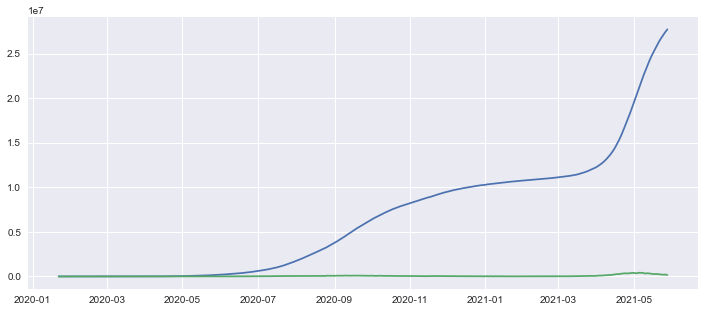

In [19]:
plt.style.use('seaborn')
plt.figure(figsize=(12,5))
# dataset.plot()
plt.plot(dataset)
plt.show()

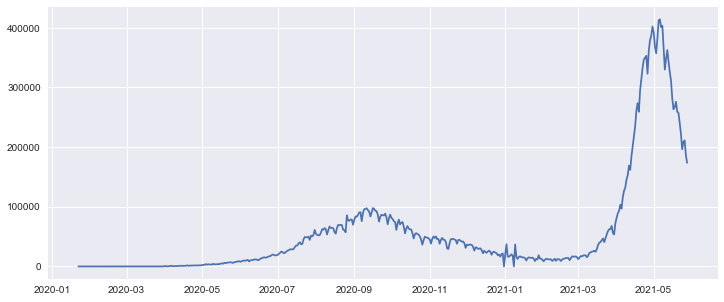

In [20]:
plt.style.use('seaborn')
plt.figure(figsize=(12,5))
plt.plot(dataset["DailyCases"])
plt.show()

## Splitting Daily Cases dataset into train and test 

In [22]:
daily=dataset.filter(['DailyCases'],axis=1)

In [23]:
daily.head(2)

,DailyCases
Date,
2020-01-22,0
2020-01-23,0


In [24]:
train_size=0.8
test_size=0.2
daily_train,daily_test = tts(daily,test_size = test_size, random_state=0, shuffle=False)

In [26]:
print("Train Count : ",daily_train.count(),"\nTest Count : ",daily_test.count())

Train Count :  DailyCases    394
dtype: int64 
Test Count :  DailyCases    99
dtype: int64


<AxesSubplot:xlabel='Date'>

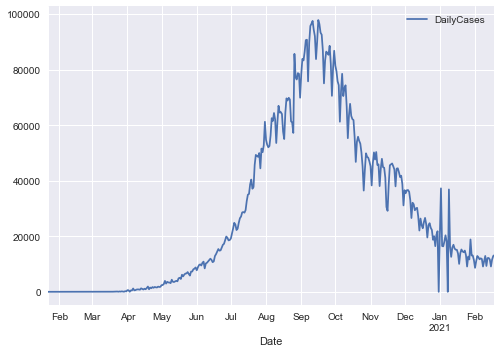

In [21]:
daily_train.plot()

<AxesSubplot:xlabel='Date'>

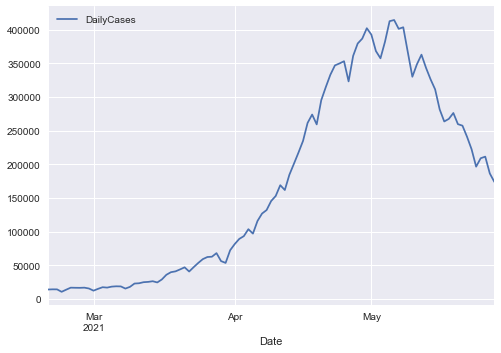

In [22]:
daily_test.plot()

## Plotting Rolling Mean and Standard Deviation of Dataset - Visual Test for Checking  Stationarity of dataset

In [46]:
def check_mean_std(ts, name):

    rolmean = ts.rolling(window=30).mean()
    rolstd = ts.rolling(window=30).std()
    plt.figure(figsize=(12,8))   
    print(name)
    
    plt.style.use('seaborn')
    plt.figure(figsize=(12,8))
    plt.plot(ts, color='red',label='Original')
    plt.plot(rolmean, color='black', label='Rolling Mean')
    plt.plot(rolstd, color='green', label = 'Rolling Std')
    plt.gcf().autofmt_xdate()
    date_format = mpl_dates.DateFormatter('%d, %b, %Y')
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.tight_layout()
    plt.xlabel("Date")
    plt.ylabel("Daily Cases")
    plt.title('COVID-19 Daily Cases Rolling Mean & Standard Deviation(India)')
    plt.legend()
    plt.show()



Daily Cases


<Figure size 864x576 with 0 Axes>

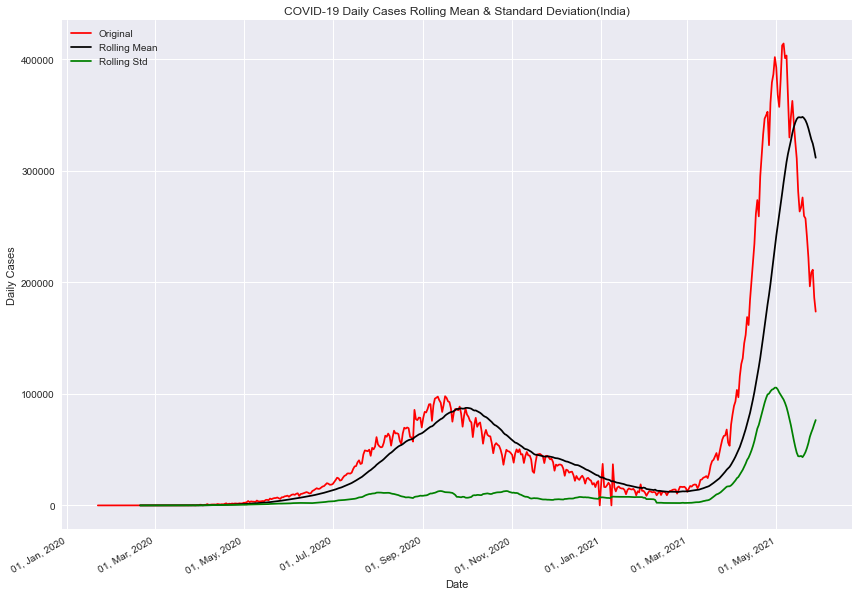

In [47]:
check_mean_std(dataset['DailyCases'],'\n\nDaily Cases')

#### The moving average is not constant but standard deviation seems to be constant.

## Performing ADF Test for checking stationarity of dataset

In [23]:
def check_adfuller(att):

    print('Results of Augmented Dickey Fuller Test:')
    print("--------For a stationary time series Test statistic is less than critical values-----------")
    dftest = adfuller(att, autolag='AIC')
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    print(dfoutput)

In [24]:
check_adfuller(dataset['DailyCases'])

Results of Augmented Dickey Fuller Test:
--------For a stationary time series Test statistic is less than critical values-----------
Test Statistic                  -4.294904
p-value                          0.000453
#Lags Used                      14.000000
Number of Observations Used    478.000000
Critical Value (1%)             -3.444105
Critical Value (5%)             -2.867606
Critical Value (10%)            -2.570001
dtype: float64


###  The p-value is very less, and the Test Statistic is less than Critical Values - So according to ADF Test the time series is somewhat stationary

## Plotting AutoCorrelationFunction(ACF) and Partial AutoCorrelation Function(PACF) Graphs
RitMat

In [27]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [28]:
daily

,DailyCases
Date,
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0
...,...
2021-05-24,196427
2021-05-25,208921
2021-05-26,211298


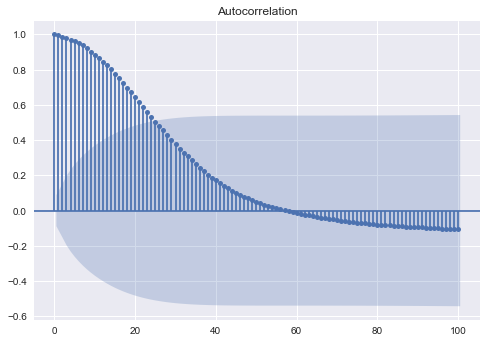

In [29]:
acf_plot = plot_acf(daily.DailyCases,lags=100)

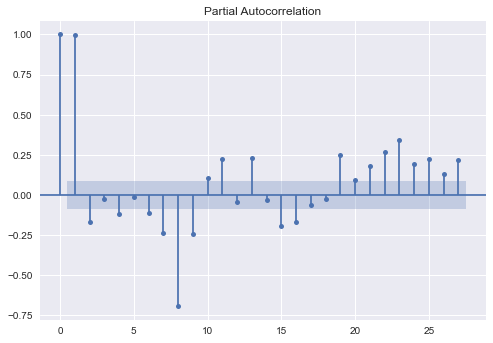

In [30]:
pacf_plot = plot_pacf(daily.DailyCases)

### Based on PACF Graph it looks like the lags 1,2,7,8,9,11,13,19 are good places to start for Auto Regressive model.

### The auto correlation function graph is decaying over time, which suggest a auto regressive process inherently. If it would have shut off immediately after some lags, it would have been close to a moving average model

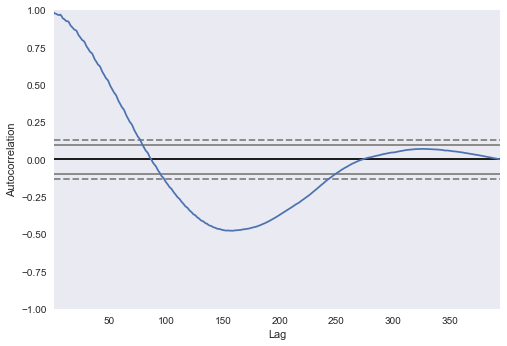

<Figure size 864x576 with 0 Axes>

In [57]:
from pandas.plotting import autocorrelation_plot  
x = autocorrelation_plot(daily_train)
   
plt.style.use('seaborn')
plt.figure(figsize=(12,8))
# ploting the Curve
x.plot()
plt.show()

Lag Value for  
    daily : 50  
    train : 100  
    test : 30
    

In [72]:
def acf_pacf_plots(dataset):
#     ts_diff = dataset - dataset.shift()
#     ts_diff.dropna(inplace=True)
    acf_result = acf(dataset,nlags=60)
    pacf_result = pacf(dataset,nlags=10, method='ols')
    
    # ACF
    plt.figure(figsize=(22,10))
    plt.style.use('seaborn')
    plt.subplot(121) 
    plt.plot(acf_result)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(dataset)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(dataset)),linestyle='--',color='gray')
    plt.xlabel("Lags")
    plt.ylabel("Autocorrelation")
    plt.title('Autocorrelation Function')
    
#     PACF
    plt.subplot(122)
    plt.style.use('seaborn')
    plt.plot(pacf_result)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(dataset)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(dataset)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.xlabel("Lags")
    plt.ylabel("Partial Autocorrelation")
    plt.tight_layout()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


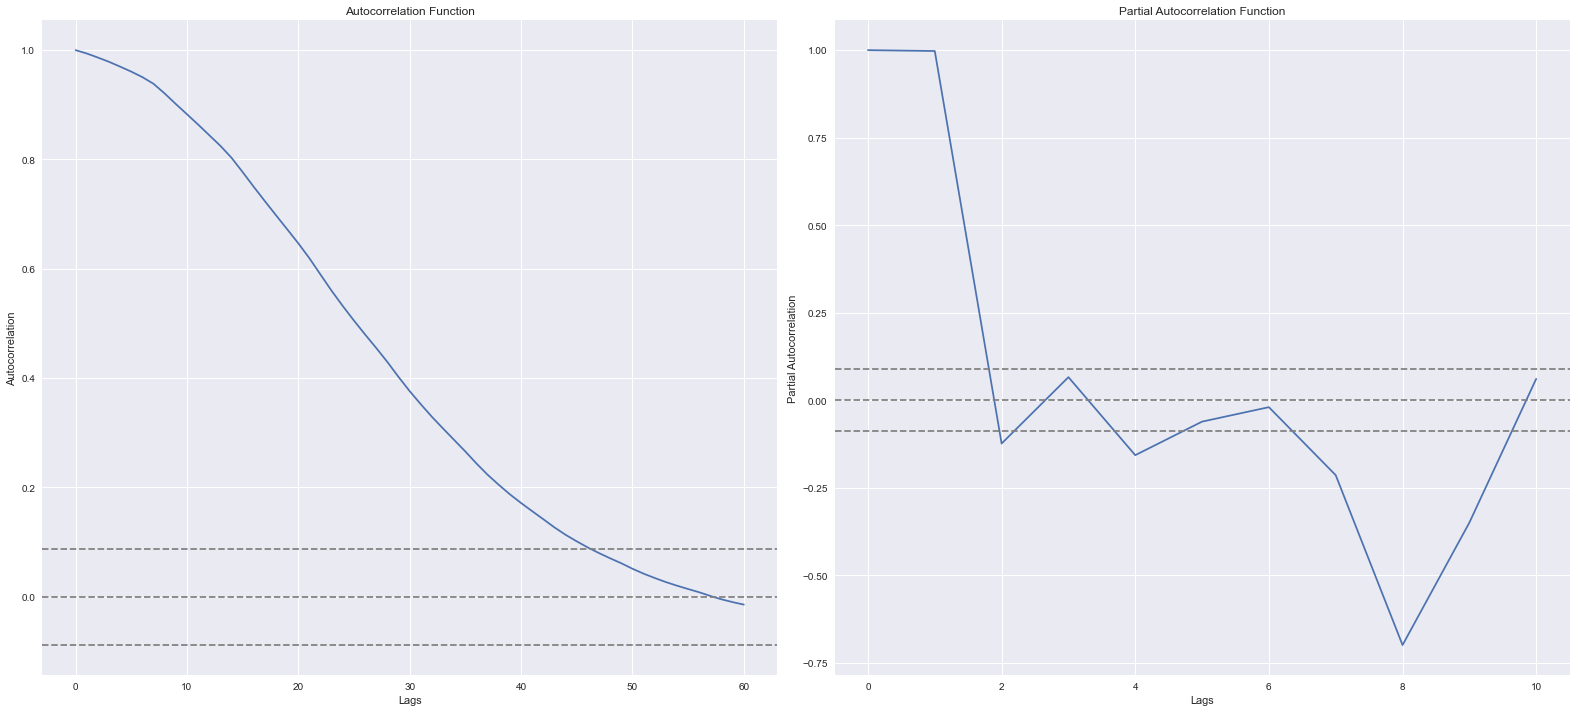

In [73]:
acf_pacf_plots(daily)

In [76]:
pip install --user pmdarima

  Using cached pmdarima-1.8.2-cp38-cp38-win_amd64.whl (596 kB)
Note: you may need to restart the kernel to use updated packages.


In [24]:
# Import the library 
from pmdarima import auto_arima 
  
# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 
  
# Fit auto_arima function to AirPassengers dataset 
stepwise_fit = auto_arima(daily_train, start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 0, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
  
# To print the summary 
stepwise_fit.summary() 

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=7711.368, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7791.917, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7742.396, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7714.145, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7789.937, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=7719.160, Time=0.11 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=7713.359, Time=0.45 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=7713.317, Time=0.53 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=7712.090, Time=0.22 sec
 ARIMA(1,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=2.02 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=7740.018, Time=0.12 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=7705.307, Time=0.28 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=7708.890, Time=0.15 sec
 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=7707.029, Time=0.45 sec
 ARIMA(2,1,1)(0,0,2)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  394
Model:             SARIMAX(1, 1, 3)x(0, 0, [1], 12)   Log Likelihood               -3814.865
Date:                              Mon, 31 May 2021   AIC                           7641.730
Time:                                      19:56:13   BIC                           7665.573
Sample:                                           0   HQIC                          7651.179
                                              - 394                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9527      0.016     58.546      0.000       0.921       0.985
ma.L1         -1.5207      0.027    -55.686      0.000      -1.574      -1.467
ma.L2          0.3384      0.044      7.702      0.000       0.252       0.424
ma.L3          0.2533      0.026      9.611      0.000       0.202       0.305
ma.S.L12      -0.3083      0.036     -8.514      0.000      -0.379      -0.237
sigma2      1.573e+07    2.1e-09   7.51e+15      0.000    1.57e+07    1.57e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              1644.05
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):             200.13   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.56e+30. Standard errors may be unstable.
"""

## -------------